In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

### Complete Dataset

In [3]:
DB2P8 = pd.read_csv("data/DB2P8.csv")
DB5 = pd.read_csv("data/DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv("data/new_point_ids.csv")

data = pd.read_csv("data/data.csv")
                  
Re_DB5 = pd.read_csv("data/R.csv")#DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

In [4]:
# Getting both DataFrames together

R = Re_DB5[["TAUTH"] + coeffs + ["id"]] 

complete_data = pd.concat([DB2, R], axis=0, ignore_index=True)
complete_data

Y = complete_data[["TAUTH"]].to_numpy()

# Adding a column for the intercept
x_df = complete_data[coeffs]
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X = x_df.to_numpy()

n, p = X.shape

model = sm.OLS(Y,X)
regression = model.fit()

In [5]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.251e+04
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:37:21   Log-Likelihood:                 1142.2
No. Observations:                6252   AIC:                            -2266.
Df Residuals:                    6243   BIC:                            -2206.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5185      0.029    -88.250      0.000      -2.574      -2.463
x1             1.1343      0.016     69.351      0.000       1.102       1.166
x2             0.0724      0.014      5.079      0.000       0.044       0.100
x3             0.1749      0.010     18.248      0.000       0.156       0.194
x4            -0.6827      0.007   -100.123      0.000      -0.696      -0.669
x5             1.4479      0.026     56.757      0.000       1.398       1.498
x6             0.2802      0.029      9.731      0.000       0.224       0.337
x7             0.0636      0.037      1.720      0.085      -0.009       0.136
x8             0.2140      0.017     12.541      0.000       0.181       0.247
==============================================================================
Omnibus:                      104.112   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.550
Skew:                          -0.149   Prob(JB):                     9.24e-38
Kurtosis:                       3.753   Cond. No.                         64.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
dfbeta_cutoff =  2/(n)**(0.5)

In [7]:
influence = regression.get_influence()
inf_sum = influence.summary_frame()

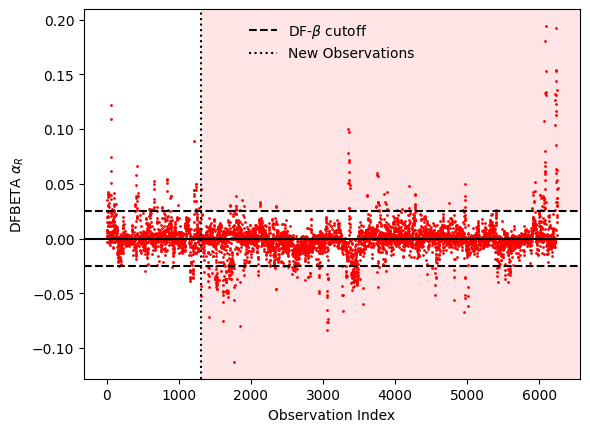

In [8]:
DBβ_αR = inf_sum["dfb_x5"]

plt.scatter(list(range( len(complete_data) )), DBβ_αR.values, s=1, c="r")
plt.axhline(dfbeta_cutoff, c="k", ls="--", label="DF-$\\beta$ cutoff")
plt.axhline(-dfbeta_cutoff, c="k", ls="--")
plt.axhline(0, c="k")
plt.axvline( complete_data[len(DB2P8):].iloc[0].name, c="k", ls=":", label="New Observations")
plt.xlabel("Observation Index")
plt.ylabel("DFBETA $\\alpha_R$")
plt.legend(loc="upper center", frameon=False)


left, bottom, width, height = (complete_data[len(DB2P8):].iloc[0].name, 
                               -dfbeta_cutoff, 
                               len(complete_data), 
                               min(DBβ_αR.values)
                              )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)

left, bottom, width, height = (complete_data[len(DB2P8):].iloc[0].name, 
                               dfbeta_cutoff, 
                               len(complete_data), 
                               max(DBβ_αR.values)
                              )
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect);

Around %80 of the complete dataset, is composed by `R`

In [9]:
infl_DB5 = DBβ_αR.iloc[len(DB2P8):]
upper_pts = infl_DB5[(infl_DB5 >  dfbeta_cutoff)].index
lower_pts = infl_DB5[(infl_DB5 < -dfbeta_cutoff)].index

infl_pts = list(upper_pts) + list(lower_pts)
len(infl_pts)

367

##### sanity check: checking that the investigated points belong to R

In [10]:
id_infl_pts = complete_data.iloc[infl_pts]["id"].values
R[R.id.isin(id_infl_pts)]

,TAUTH,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,id
39,-2.758607,-0.226023,0.838545,2.091617,1.477049,0.500775,0.452985,-1.190130,0.693147,IWDT1O
90,-2.499817,-0.226023,0.698632,1.985543,0.993252,0.494696,0.456158,-1.180669,0.693147,TSCBBV
97,-3.303345,-0.225772,0.704087,2.118542,1.922788,0.492254,0.444686,-1.168938,0.693147,5YCYNE
98,-3.363324,-0.226650,0.704087,2.181547,1.911023,0.489193,0.435671,-1.157648,0.693147,C4ZXA5
103,-3.273596,-0.225396,0.705076,2.128113,1.900614,0.492254,0.447247,-1.171301,0.693147,YWYPKG
...,...,...,...,...,...,...,...,...,...,...
4934,-4.215157,-1.510045,0.684106,1.557723,-0.484346,-0.191161,0.099845,-1.360008,0.693147,NBJA0D
4937,-4.094745,-1.515037,0.674474,1.593105,-0.486946,-0.189467,0.102557,-1.347185,0.693147,NGC85H
4938,-4.068677,-1.514582,0.668854,1.631004,-0.452871,-0.179605,0.096219,-1.354725,0.693147,ID1IP4
4940,-1.753886,-0.020815,1.567574,1.252763,1.631591,0.897719,-0.000300,-1.116746,0.693147,D26CA1


### Regression with and without influential points of $\alpha_R$

In [11]:
# Getting both DataFrames together: influential | maximizes

R_infl =  R[R.id.isin(id_infl_pts)]

infl_data = pd.concat([DB2, R_infl], axis=0, ignore_index=True)
infl_data

Y = infl_data[["TAUTH"]].to_numpy()

# Adding a column for the intercept
x_df = infl_data[coeffs]
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X = x_df.to_numpy()

n, p = X.shape

model = sm.OLS(Y,X)
regression = model.fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3145.
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:37:56   Log-Likelihood:                 1.4489
No. Observations:                1677   AIC:                             15.10
Df Residuals:                    1668   BIC:                             63.93
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6213      0.054    -48.754      0.000      -2.727      -2.516
x1             1.0670      0.030     35.711      0.000       1.008       1.126
x2             0.2371      0.028      8.503      0.000       0.182       0.292
x3             0.1068      0.022      4.937      0.000       0.064       0.149
x4            -0.5759      0.016    -36.900      0.000      -0.607      -0.545
x5             1.4856      0.049     30.616      0.000       1.390       1.581
x6             0.2608      0.050      5.165      0.000       0.162       0.360
x7             0.0363      0.065      0.563      0.574      -0.090       0.163
x8             0.0718      0.039      1.859      0.063      -0.004       0.147
==============================================================================
Omnibus:                       35.653   Durbin-Watson:                   0.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.806
Skew:                          -0.342   Prob(JB):                     6.17e-09
Kurtosis:                       3.270   Cond. No.                         43.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Getting both DataFrames together: not influential | minimizes

R_not_infl =  R[~R.id.isin(id_infl_pts)]

not_infl_data = pd.concat([DB2, R_not_infl], axis=0, ignore_index=True)
not_infl_data

Y = not_infl_data[["TAUTH"]].to_numpy()

# Adding a column for the intercept
x_df = not_infl_data[coeffs]
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X = x_df.to_numpy()

n, p = X.shape

model = sm.OLS(Y,X)
regression = model.fit()

regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.483e+04
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:37:56   Log-Likelihood:                 1882.6
No. Observations:                5885   AIC:                            -3747.
Df Residuals:                    5876   BIC:                            -3687.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5055      0.026    -97.670      0.000      -2.556      -2.455
x1             1.1281      0.016     71.830      0.000       1.097       1.159
x2             0.0252      0.014      1.863      0.062      -0.001       0.052
x3             0.2204      0.009     24.265      0.000       0.203       0.238
x4            -0.7000      0.006   -112.043      0.000      -0.712      -0.688
x5             1.4853      0.025     59.267      0.000       1.436       1.534
x6             0.2297      0.026      8.690      0.000       0.178       0.282
x7             0.1027      0.035      2.964      0.003       0.035       0.171
x8             0.2449      0.016     15.764      0.000       0.214       0.275
==============================================================================
Omnibus:                       28.630   Durbin-Watson:                   0.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.790
Skew:                           0.019   Prob(JB):                     2.29e-09
Kurtosis:                       3.401   Cond. No.                         68.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


---


### General Influential Points

High Residual and High Leverage

In [13]:
student_resid = influence.resid_studentized_external
leverage = influence.hat_matrix_diag
cutoff_leverage = ((2*p)+2)/n
cutoff_student_resid = 1

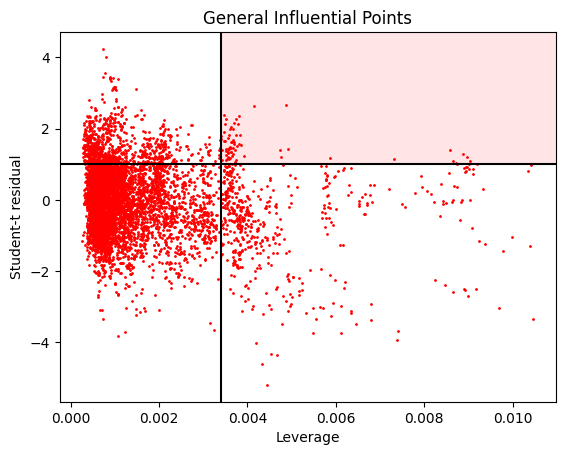

In [14]:
plt.scatter(leverage, student_resid, s=1, c="r")
plt.ylabel("Student-t residual")
plt.xlabel("Leverage")
plt.axvline(cutoff_leverage, c="k")
plt.axhline(cutoff_student_resid, c="k")

left, bottom, width, height = cutoff_leverage, cutoff_student_resid, max(leverage), max(student_resid)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="red")
plt.gca().add_patch(rect)
plt.title("General Influential Points");

In [15]:
#plt.scatter(list(range(len(complete_data))),inf_sum["cooks_d"], s=1, c="r");

In [16]:
ge_infl = (pd.DataFrame([leverage,student_resid]).T).rename(columns={0:"leverage",1:"t_resid"})
ge_infl = ge_infl[ge_infl.leverage > cutoff_leverage]
ge_infl = ge_infl[ge_infl.t_resid  > cutoff_student_resid]
gen_infl_pts = list(ge_infl.index)

### Regression with and without influential points

In [17]:
# Getting both DataFrames together: influential

R_infl =  R[R.index.isin(gen_infl_pts)]

infl_data = pd.concat([DB2, R_infl], axis=0, ignore_index=True)
infl_data

Y = infl_data[["TAUTH"]].to_numpy()

# Adding a column for the intercept
x_df = infl_data[coeffs]
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X = x_df.to_numpy()

n, p = X.shape

model = sm.OLS(Y,X)
regression = model.fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     5792.
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:37:57   Log-Likelihood:                 586.13
No. Observations:                1337   AIC:                            -1154.
Df Residuals:                    1328   BIC:                            -1107.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9916      0.048    -62.445      0.000      -3.086      -2.898
x1             0.7854      0.025     31.351      0.000       0.736       0.835
x2             0.3204      0.027     11.924      0.000       0.268       0.373
x3             0.4321      0.019     22.461      0.000       0.394       0.470
x4            -0.6703      0.013    -53.085      0.000      -0.695      -0.646
x5             2.2139      0.049     45.566      0.000       2.119       2.309
x6             0.3912      0.040      9.794      0.000       0.313       0.470
x7             0.5729      0.050     11.487      0.000       0.475       0.671
x8             0.1721      0.029      5.881      0.000       0.115       0.230
==============================================================================
Omnibus:                       36.970   Durbin-Watson:                   0.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.513
Skew:                          -0.252   Prob(JB):                     3.24e-13
Kurtosis:                       3.883   Cond. No.                         50.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# Getting both DataFrames together: not influential

R_infl =  R[~R.index.isin(gen_infl_pts)]

infl_data = pd.concat([DB2, R_infl], axis=0, ignore_index=True)
infl_data

Y = infl_data[["TAUTH"]].to_numpy()

# Adding a column for the intercept
x_df = infl_data[coeffs]
x_df.insert(loc = 0, column = "intercept", value = np.ones(len(x_df)))
X = x_df.to_numpy()

n, p = X.shape

model = sm.OLS(Y,X)
regression = model.fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.245e+04
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:37:57   Log-Likelihood:                 1129.0
No. Observations:                6225   AIC:                            -2240.
Df Residuals:                    6216   BIC:                            -2179.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5190      0.029    -88.027      0.000      -2.575      -2.463
x1             1.1347      0.016     69.204      0.000       1.103       1.167
x2             0.0720      0.014      5.041      0.000       0.044       0.100
x3             0.1743      0.010     18.116      0.000       0.155       0.193
x4            -0.6824      0.007    -99.663      0.000      -0.696      -0.669
x5             1.4468      0.026     56.501      0.000       1.397       1.497
x6             0.2800      0.029      9.706      0.000       0.223       0.337
x7             0.0620      0.037      1.674      0.094      -0.011       0.135
x8             0.2146      0.017     12.510      0.000       0.181       0.248
==============================================================================
Omnibus:                      102.705   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.481
Skew:                          -0.149   Prob(JB):                     4.29e-37
Kurtosis:                       3.747   Cond. No.                         64.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print(
    f"Influence of DB2: {round((len(np.where(np.array(gen_infl_pts) < len(DB2))[0])/len(gen_infl_pts))*100,2)}%"+
    "\n"+
    f"Influence of DB5: {round((len(np.where(np.array(gen_infl_pts) > len(DB2))[0])/len(gen_infl_pts))*100,2)}%"
)

Influence of DB2: 28.57%
Influence of DB5: 71.43%


In [20]:
len(infl_data)

6225